# Problem Description

Develop a machine learning system to predict final CGPA of a student at the end of fourth year given GPs of the courses obtained in initial years (up to first, second or third year). 

Model 1: predict final CGPA based on GPs of first year only.


Model 2: predict final CGPA based on GPs of first two years.


Model 3: predict final CGPA based on GPs of first three years.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from math import ceil
from tabulate import tabulate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import warnings
warnings.filterwarnings('ignore')

try:
    from ipywidgets import widgets
    from ipywidgets import Button, HBox, VBox
except ModuleNotFoundError:
    !pip install ipywidgets

## Load the Dataset

In [2]:
# Reading the CSV file present in the Project Folder using Padas read_csv method

df = pd.read_csv("The_Grades_Dataset.csv")

## Exploratory Data Analysis

In [3]:
rows, columns = df.shape
print(f"The given dataset contains {rows} rows and {columns} columns")

The given dataset contains 571 rows and 43 columns


In [4]:
# Examining first 10 rows
df.head(10)

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,...,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
0,CS-97001,B-,D+,C-,C,C-,D+,D,C-,B-,...,C-,C-,C-,C-,A-,A,C-,B,A-,2.205
1,CS-97002,A,D,D+,D,B-,C,D,A,D+,...,D+,D,C,D,A-,B-,C,C,B,2.008
2,CS-97003,A,B,A,B-,B+,A,B-,B+,A-,...,B,B,A,C,A,A,A,A-,A,3.608
3,CS-97004,D,C+,D+,D,D,A-,D+,C-,D,...,D+,C,D+,C-,B-,B,C+,C+,C+,1.906
4,CS-97005,A-,A-,A-,B+,A,A,A-,B+,A,...,B-,B+,B+,B-,A-,A,A-,A-,A,3.448
5,CS-97006,A,B-,B,D+,C+,A-,C+,B,B+,...,C,B-,C+,C+,A-,A-,B+,B-,B,3.026
6,CS-97007,B-,C-,A-,D,A-,B,A,B+,A-,...,B-,C,B+,B-,A,A-,B+,B+,A,2.957
7,CS-97008,B+,B+,C+,C,C,A-,C-,A-,B,...,D+,B+,B+,C,A,B+,A-,A-,A-,3.043
8,CS-97009,A-,C,A-,D+,B,A-,A-,A-,B+,...,B+,B,B-,C+,A,A-,B+,A-,A,3.358
9,CS-97010,A,B,C+,B,B,A-,C,B-,A-,...,C+,B-,B+,B-,A,A,A-,B,A,3.247


In [5]:
# Examining last 10 rows
df.tail(10)

,Seat No.,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,...,CS-312,CS-317,CS-403,CS-421,CS-406,CS-414,CS-419,CS-423,CS-412,CGPA
561,CS-97562,B-,B,A-,B+,B-,B+,A-,A,B,...,B+,B-,B+,D+,C+,B-,B+,C,C+,2.828
562,CS-97563,B,B,A,C,B,B+,B,C-,B+,...,A-,B,B+,B+,B+,C+,A-,D+,C+,2.821
563,CS-97564,A-,B,A,D+,B+,A-,C,A,C+,...,B+,C,B+,C-,C-,C,F,D,C,2.612
564,CS-97565,A-,D,A,C,B+,B+,C,A-,B-,...,B,C+,B+,D+,C,C-,B,C,B-,2.607
565,CS-97566,F,F,D,C-,NaN,D+,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.800
566,CS-97567,B,A,A,A-,A+,A,A-,A-,A+,...,A-,A-,A,A,A,B+,B+,B,A,3.798
567,CS-97568,A+,A,A,A,A,A,A,A-,A,...,B+,B+,A,A,A-,B,A-,C,A-,3.772
568,CS-97569,B,A,A-,B+,A,A,A,A,A,...,A-,B,A,B+,A,C,B+,A-,A-,3.470
569,CS-97570,A,B+,D,A,D,D+,B-,C-,B-,...,D,B,B,C-,D,C,B,B-,C,2.193
570,CS-97571,C,D,D,C,C,D+,B,C+,C,...,C+,C,B-,D,F,C-,B+,D,C-,1.753


In [6]:
# The only numerical variable present is CGPA

df.describe()

,CGPA
count,571.000000
mean,2.954888
std,0.620552
min,0.800000
25%,2.538000
50%,3.029000
75%,3.451000
max,3.985000


In [7]:
# 42 Categorical Variables with some null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 43 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Seat No.   571 non-null    object 
 1   PH-121     571 non-null    object 
 2   HS-101     571 non-null    object 
 3   CY-105     570 non-null    object 
 4   HS-105/12  570 non-null    object 
 5   MT-111     569 non-null    object 
 6   CS-105     571 non-null    object 
 7   CS-106     569 non-null    object 
 8   EL-102     569 non-null    object 
 9   EE-119     569 non-null    object 
 10  ME-107     569 non-null    object 
 11  CS-107     569 non-null    object 
 12  HS-205/20  566 non-null    object 
 13  MT-222     566 non-null    object 
 14  EE-222     564 non-null    object 
 15  MT-224     564 non-null    object 
 16  CS-210     564 non-null    object 
 17  CS-211     566 non-null    object 
 18  CS-203     566 non-null    object 
 19  CS-214     565 non-null    object 
 20  EE-217    

In [8]:
# Checking the Unique Values of Each Column
df.apply(pd.Series.unique)

Seat No.     [CS-97001, CS-97002, CS-97003, CS-97004, CS-97...
PH-121         [B-, A, D, A-, B+, B, C+, C, C-, D+, WU, A+, F]
HS-101             [D+, D, B, C+, A-, B-, C-, B+, C, A, A+, F]
CY-105       [C-, D+, A, A-, B, C+, B+, B-, C, D, nan, WU, ...
HS-105/12    [C, D, B-, B+, D+, B, C-, C+, A-, A, nan, WU, ...
MT-111       [C-, B-, B+, D, A, C+, A-, C, B, D+, nan, A+, ...
CS-105                [D+, C, A, A-, B, B-, B+, C+, C-, A+, D]
CS-106       [D, B-, D+, A-, C+, A, C-, C, B, B+, nan, A+, ...
EL-102       [C-, A, B+, B, A-, B-, C, C+, D+, D, nan, A+, ...
EE-119       [B-, D+, A-, D, A, B+, B, C-, C+, C, WU, nan, A+]
ME-107       [C-, D, A-, C+, B+, A, D+, C, B, B-, WU, nan, ...
CS-107       [C-, B+, B-, D, C, A-, C+, D+, B, A, nan, A+, ...
HS-205/20    [B+, C+, A-, B, A, B-, nan, D, WU, A+, C, D+, ...
MT-222       [D, B-, A, D+, C, B+, A-, B, C+, nan, C-, WU, ...
EE-222       [A-, C-, A, B-, B+, C+, D+, B, nan, C, W, A+, ...
MT-224       [B-, D+, A, D, A-, C-, C, B+, C+, B, nan, 

In [9]:
# Example Row
df.apply(pd.Series.unique).values[18]

array(['D+', 'C', 'A', 'C+', 'A-', 'B+', 'B', 'B-', 'C-', nan, 'D', 'A+',
       'I', 'F'], dtype=object)

### Unique Values

The most repeated unique grades are,

    A+, A, A-, B+, B, B-, C+, C, C-, D+, D , F 

Grade W stands for Withdrawal \
Grade WU stands for Withdrawal Unauthorized \
Grade I stands for Incomplete 

**Withdrawal (W)** \
A withdrawal from a class (W) is GPA-neutral: instead of a grade, you receive a W notation on your transcript which does not affect your GPA; you also don't earn credits for the course.

**Withdrawal Unauthorized (WU)** \
A withdrawal from a class (W) is not GPA-neutral, for purposes of grade point average and progress point computation this symbol is equivalent to an "F".

**Incomplete Grade (I)** \
An Incomplete grade, in the GPA computations, has the same effect as a grade F.

### Missing Values

We assume that the missing values indicate that the student hasn't taken that specific course, but if there are too many missing values we will have to drop it as it is an outlier and will affect model performance

In [10]:
# Checking missing values with respect to each row

for index, i in enumerate(df.isnull().sum(axis=1).to_list()):
    if i:
        print(index,": ",i)

44 :  36
60 :  24
86 :  7
91 :  19
137 :  30
142 :  31
143 :  30
281 :  20
282 :  14
283 :  1
284 :  1
285 :  1
286 :  1
287 :  1
288 :  24
289 :  1
290 :  1
291 :  1
292 :  1
293 :  1
294 :  1
295 :  1
296 :  1
297 :  1
298 :  1
299 :  1
300 :  1
301 :  1
302 :  1
303 :  1
304 :  1
305 :  1
306 :  1
307 :  1
308 :  1
309 :  1
310 :  1
311 :  1
312 :  1
313 :  1
314 :  1
315 :  1
316 :  1
317 :  1
318 :  1
319 :  1
320 :  1
321 :  1
322 :  1
323 :  1
324 :  1
325 :  1
326 :  1
327 :  1
328 :  1
329 :  1
330 :  1
331 :  1
332 :  1
333 :  1
334 :  1
335 :  1
336 :  1
337 :  1
338 :  1
339 :  1
340 :  1
341 :  1
342 :  1
343 :  1
344 :  1
345 :  1
346 :  1
347 :  1
348 :  1
349 :  1
350 :  1
351 :  1
352 :  1
353 :  1
354 :  1
355 :  1
356 :  1
357 :  1
358 :  1
359 :  1
360 :  1
361 :  1
362 :  1
363 :  1
364 :  1
365 :  1
366 :  1
367 :  1
368 :  1
369 :  1
370 :  1
371 :  1
372 :  1
373 :  1
374 :  1
375 :  1
376 :  1
377 :  1
378 :  1
379 :  1
380 :  1
381 :  1
382 :  1
383 :  1
384 :

### Irrelevant Values

Seat No. is different for each student and does not contribute in predicting the CGPA.
Courses starting with 4 are Final year courses and we have to predict GPA based on GPs of first three years or two years or first year only, hence they will not be used and we will simply drop them.

In [11]:
print(df.columns)

Index(['Seat No.', 'PH-121', 'HS-101', 'CY-105', 'HS-105/12', 'MT-111',
       'CS-105', 'CS-106', 'EL-102', 'EE-119', 'ME-107', 'CS-107', 'HS-205/20',
       'MT-222', 'EE-222', 'MT-224', 'CS-210', 'CS-211', 'CS-203', 'CS-214',
       'EE-217', 'CS-212', 'CS-215', 'MT-331', 'EF-303', 'HS-304', 'CS-301',
       'CS-302', 'TC-383', 'MT-442', 'EL-332', 'CS-318', 'CS-306', 'CS-312',
       'CS-317', 'CS-403', 'CS-421', 'CS-406', 'CS-414', 'CS-419', 'CS-423',
       'CS-412', 'CGPA'],
      dtype='object')


## Data Preprocessing

### Steps

1. Drop columns Seat No, CS-403, CS-421, CS-406, CS-414, CS-419, CS-423, CS-412
2. Fill all missing values with 0.
3. Replace Grade W and Grade I with Grade F to make encoding simpler.
4. Encode all the grades

#### Drop Irrelevant Features

In [12]:
# Seat_No. has no effect on CGPA so we will drop it
# Also the grades of fourth year will not be used by model

df = df.drop(["Seat No.", "CS-403", "CS-421", "CS-406", "CS-414", "CS-419", "CS-423", "CS-412"], axis=1)

#### Handle Missing Values

In [13]:
# We can drop the row if there are too many misisng values
# Lets set are threshold to 23

df = df.drop(df[df.isnull().sum(axis=1) >= 23].index)

# Now the remaining null values are filled by 0, assuming the student hasn't opted for that course yet
# Setting to 0 to show that this grade won't affect the final CGPA

df = df.fillna(0)

In [14]:
# All columnns have 566 not-null values

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 570
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PH-121     566 non-null    object 
 1   HS-101     566 non-null    object 
 2   CY-105     566 non-null    object 
 3   HS-105/12  566 non-null    object 
 4   MT-111     566 non-null    object 
 5   CS-105     566 non-null    object 
 6   CS-106     566 non-null    object 
 7   EL-102     566 non-null    object 
 8   EE-119     566 non-null    object 
 9   ME-107     566 non-null    object 
 10  CS-107     566 non-null    object 
 11  HS-205/20  566 non-null    object 
 12  MT-222     566 non-null    object 
 13  EE-222     566 non-null    object 
 14  MT-224     566 non-null    object 
 15  CS-210     566 non-null    object 
 16  CS-211     566 non-null    object 
 17  CS-203     566 non-null    object 
 18  CS-214     566 non-null    object 
 19  EE-217     566 non-null    object 
 20  CS-212    

#### Encoding Variables

In [15]:
# Replace WU and I with F Replace W with 0 (No effect on gpa)
df = df.replace({"WU":"F",
                 "I":"F",
                 "W":"0"})

In [16]:
# Checking the Data again
df.apply(pd.Series.unique)

PH-121             [B-, A, D, A-, B+, B, C+, C, C-, D+, F, A+]
HS-101                [D+, D, B, C+, A-, B-, C-, B+, C, A, A+]
CY-105             [C-, D+, A, A-, B, C+, B+, B-, C, D, F, A+]
HS-105/12          [C, D, B-, B+, D+, B, C-, C+, A-, A, A+, F]
MT-111             [C-, B-, B+, D, A, C+, A-, C, B, D+, A+, F]
CS-105                [D+, C, A, A-, B, B-, B+, C+, C-, A+, D]
CS-106          [D, B-, D+, A-, C+, A, C-, C, B, B+, A+, F, 0]
EL-102             [C-, A, B+, B, A-, B-, C, C+, D+, D, A+, F]
EE-119          [B-, D+, A-, D, A, B+, B, C-, C+, C, F, 0, A+]
ME-107             [C-, D, A-, C+, B+, A, D+, C, B, B-, F, A+]
CS-107             [C-, B+, B-, D, C, A-, C+, D+, B, A, A+, F]
HS-205/20          [B+, C+, A-, B, A, B-, D, F, A+, C, D+, C-]
MT-222          [D, B-, A, D+, C, B+, A-, B, C+, C-, F, A+, 0]
EE-222       [A-, C-, A, B-, B+, C+, D+, B, C, 0, 0, A+, D, F]
MT-224       [B-, D+, A, D, A-, C-, C, B+, C+, B, A+, 0, F, 0]
CS-210       [C+, D+, A, C, A-, B+, B-, B, D, A+, 0, C-

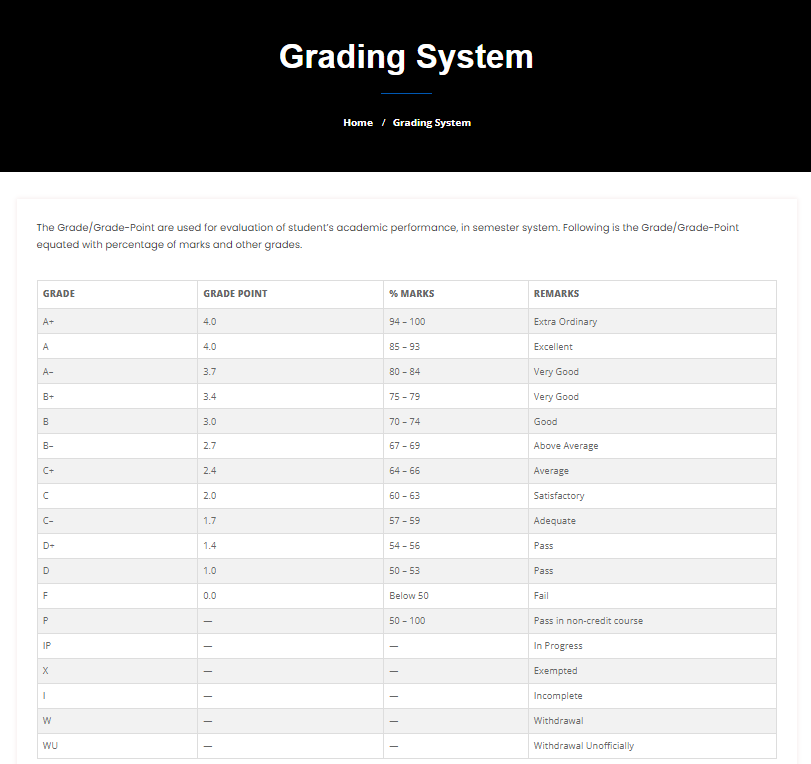

Now we will encode the grades with respect to grade points
We have given the weight of 0 to the null values, thus we will give a weight of 1 for F and and other grades in accordance to it.

In [17]:
grade_points = {"F":  1.0,
                "D":  2.0,
                "D+": 2.4,
                "C-": 2.7,
                "C":  3.0,
                "C+": 3.4,
                "B-": 3.7,
                "B":  4.0,
                "B+": 4.4,
                "A-": 4.7,
                "A":  5.0,
                "A+": 5.0 }

In [18]:
# Encoding all the Grades to their respective weights

df = df.replace(grade_points)

In [19]:
df.head()

,PH-121,HS-101,CY-105,HS-105/12,MT-111,CS-105,CS-106,EL-102,EE-119,ME-107,...,CS-301,CS-302,TC-383,MT-442,EL-332,CS-318,CS-306,CS-312,CS-317,CGPA
0,3.7,2.4,2.7,3.0,2.7,2.4,2.0,2.7,3.7,2.7,...,4.0,3.0,3.4,4.4,3.0,2.7,3.0,2.7,2.7,2.205
1,5.0,2.0,2.4,2.0,3.7,3.0,2.0,5.0,2.4,2.0,...,4.7,2.4,2.7,2.7,3.0,4.7,2.0,2.4,2.0,2.008
2,5.0,4.0,5.0,3.7,4.4,5.0,3.7,4.4,4.7,4.7,...,4.4,4.7,4.0,5.0,4.4,4.7,4.7,4.0,4.0,3.608
3,2.0,3.4,2.4,2.0,2.0,4.7,2.4,2.7,2.0,3.4,...,2.0,3.7,2.4,2.7,2.4,4.4,2.7,2.4,3.0,1.906
4,4.7,4.7,4.7,4.4,5.0,5.0,4.7,4.4,5.0,4.7,...,3.7,4.7,3.4,4.7,4.7,3.7,4.7,3.7,4.4,3.448


### Correlation Matrix

<AxesSubplot:>

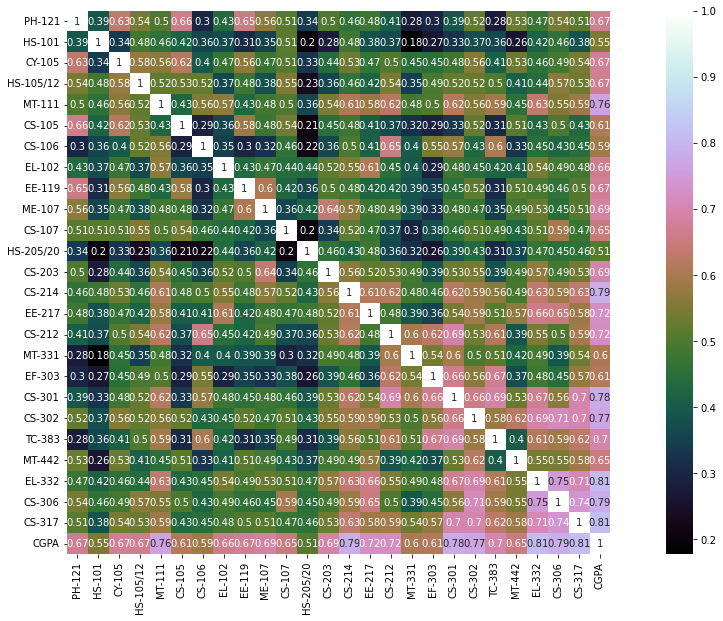

In [20]:
# GETTING a Correllation matrix
corr_mat=df.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

### Encoding Function

In [21]:
# We have written an encoding function to encode any new data

def encode_data(input_df):
    """
    Input: PandasDataFrame
    
        Encode the gradepoints for model training
        
    Returns: PandasDataFrame
    """
    df = input_df.fillna(0)
    df = df.replace({"WU":"F",
                     "I":"F",
                     "W":"0"})
    
    grade_points = {"F":  1.0,
                "D":  2.0,
                "D+": 2.4,
                "C-": 2.7,
                "C":  3.0,
                "C+": 3.4,
                "B-": 3.7,
                "B":  4.0,
                "B+": 4.4,
                "A-": 4.7,
                "A":  5.0,
                "A+": 5.0 }
    
    df = df.replace(grade_points)
    
    return df

## Model Training

#### Input Features and Target Variable

In [22]:
X = df.drop("CGPA", axis=1)
y = df[['CGPA']]

#### Splitting the Dataset

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Preparing Dataset for Model 1, Model 2 and Model 3

In [24]:
columns = df.columns.to_list()
first_year, first_two_years = [],[]
for i in columns:
    if i[3] == '1':
        first_year.append(i)
        first_two_years.append(i)
    elif i[3] == '2':
        first_two_years.append(i)
        
first_three_years = list(X.columns)    

first_year, first_two_years, first_three_years
len(first_three_years)

34

### Model 1

#### DataFrame for Model 1

In [25]:
df1 = df[first_year + ["CGPA"]]
x1 = df1.drop("CGPA", axis=1)
y1 = df1[['CGPA']]
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, random_state=0)

#### Linear Regression

In [26]:
reg1 = linear_model.LinearRegression()
reg1.fit(X_train1, y_train1)
r1 = reg1.score(X_test1, y_test1)
r1

0.8528178556784193

#### Gradient Boosting Regressor

In [27]:
grad1 = GradientBoostingRegressor()
grad1.fit(X_train1, y_train1)
g1 = grad1.score(X_test1, y_test1)
g1

0.841288213333247

### Model 2

#### DataFrame for Model 2

In [28]:
df2 = df[first_two_years + ["CGPA"]]
x2 = df2.drop("CGPA", axis=1)
y2 = df2[['CGPA']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=0)

#### Linear Regression

In [29]:
reg2 = linear_model.LinearRegression()
reg2.fit(X_train2, y_train2)
r2 = reg2.score(X_test2, y_test2)
r2

0.9357958398633757

#### Gradient Boosting Regressor

In [30]:
grad2 = GradientBoostingRegressor()
grad2.fit(X_train2, y_train2)
g2 = grad2.score(X_test2, y_test2)
g2

0.9346436390098302

### Model 3

#### DataFrame for Model 3

In [31]:
df3 = df[columns]
x3 = df3.drop("CGPA", axis=1)
y3 = df3[['CGPA']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, random_state=0)

#### Linear Regression

In [32]:
reg3 = linear_model.LinearRegression()
reg3.fit(X_train3, y_train3)
r3 = reg3.score(X_test3, y_test3)
r3

0.9539986400968821

#### Gradient Boosting Regressor

In [33]:
grad3 = GradientBoostingRegressor()
grad3.fit(X_train3, y_train3)
g3 = grad3.score(X_test3, y_test3)
g3

0.9571929324199087

### Testing More Algorithms on these Models

### Model 1

#### Lasso Regression

In [34]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train1, y_train1)
ls1 = lasso.score(X_test1, y_test1)
ls1

0.7809031836646567

#### Ridge Regression

In [35]:
ridge = linear_model.Ridge(alpha=0.1)
ridge.fit(X_train1, y_train1)
rg1 = ridge.score(X_test1, y_test1)
rg1

0.8528237431378562

#### ElasticNet Regression

In [36]:
elasticnet = linear_model.ElasticNet(alpha=0.1)
elasticnet.fit(X_train1, y_train1)
en1 = elasticnet.score(X_test1, y_test1)
en1

0.8293238869581793

### Model 3

#### Huber Regression

In [37]:
huber = linear_model.HuberRegressor()
huber.fit(X_train3, y_train3)
hb3 = huber.score(X_test3, y_test3)
hb3

0.9354373511592133

#### Decision Tree Regressor

In [38]:
dtreg = DecisionTreeRegressor()
dtreg.fit(X_train3, y_train3)
dt3 = dtreg.score(X_test3, y_test3)
dt3

0.8601074100696098

#### KNeighbours Regressor

In [39]:
knreg = KNeighborsRegressor()
knreg.fit(X_train3, y_train3)
kn3 = knreg.score(X_test3, y_test3)
kn3

0.9422129211873128

## Model Evaluation

In [40]:
# A snippet of code takes from sklearn official website in order to visulize model learning and crossvalidation curve
# in order to test for overfitting

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.
    
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

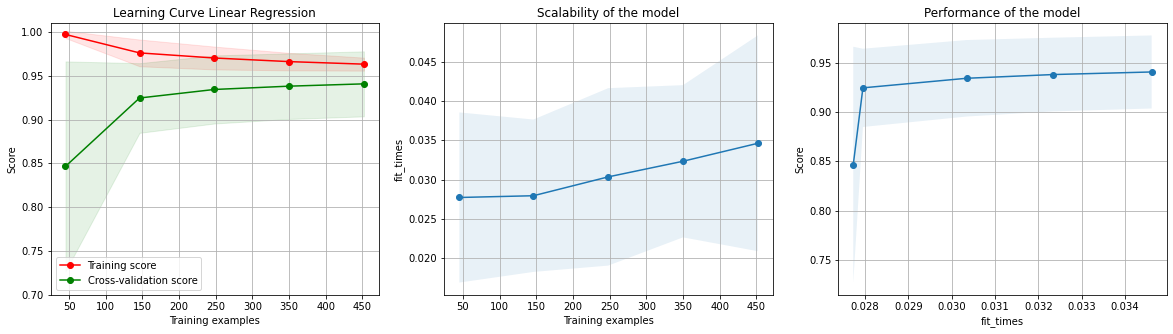

In [41]:
title = "Learning Curve Linear Regression"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = linear_model.LinearRegression()

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ibrahim/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

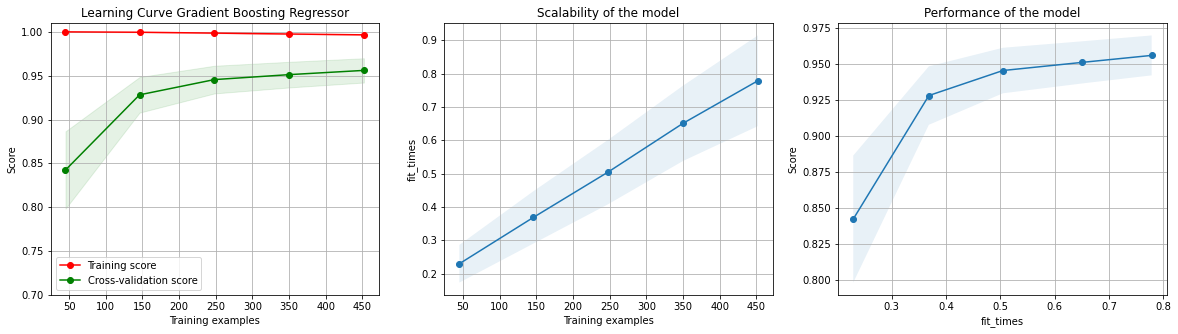

In [42]:
title = "Learning Curve Gradient Boosting Regressor"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GradientBoostingRegressor()

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

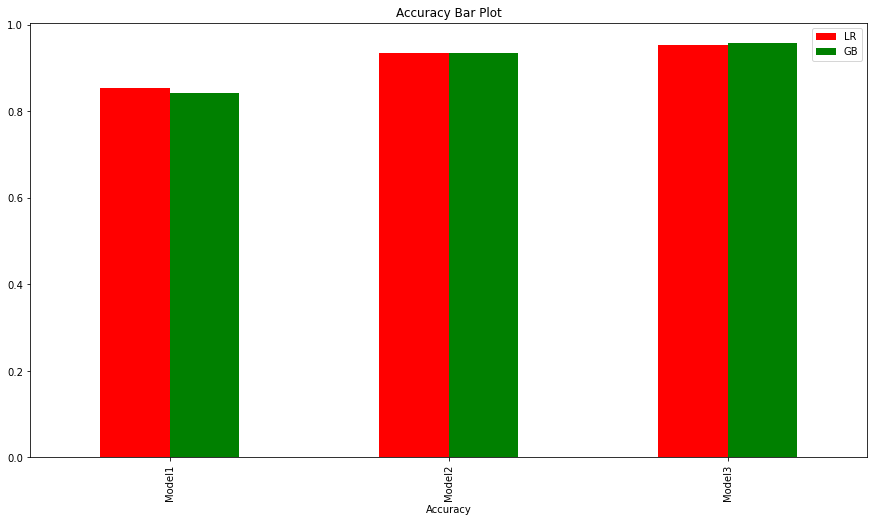

In [43]:
x = ['LR1', 'LR2', 'LR3']
y = [r1,r2,r3]

plotdata = pd.DataFrame({

    "LR":[r1,r2,r3],

    "GB":[g1,g2,g3]},

    index=["Model1", "Model2", "Model3"])

plotdata.plot(kind="bar",figsize=(15, 8), color=["red","green"])
plt.xlabel('Accuracy')
plt.title('Accuracy Bar Plot')
plt.show()

In [44]:
table = [["Models", 1, 2, 3],["Linear Regression",r1,r2,r3],["Gradient Boosting Regressor",g1,g2,g3]]
print(tabulate(table))

---------------------------  --------  --------  --------
Models                       1         2         3
Linear Regression            0.852818  0.935796  0.953999
Gradient Boosting Regressor  0.841288  0.934644  0.957193
---------------------------  --------  --------  --------


#### Finalizing Models
Linear Regression for model1 \
Gradient Boosting Regressor for model2 and model3

## Model Deployment

In [45]:
prediction_input = pd.DataFrame()


def display_menu(model, course_grades):    
    columns = course_grades
    def btn_eventhandler(obj):
        global prediction_input
        del prediction_input
        grade_points = []
        for i in course_grades:
            grade_points.append(i.value)
        prediction_input = pd.DataFrame([grade_points], columns=columns)
        prediction_input = encode_data(prediction_input)
        print("The predicted CGPA is:", model.predict(prediction_input))


    grades = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'F', "W", "WU", "I"]

    course_grades = []
    for i in columns:
        x = widgets.Dropdown(options=grades, description=i, value=None)
        course_grades.append(x)

    left_box, centre_box, right_box = [],[],[]

    for i in range(ceil(len(course_grades)/3)):
        left_box.append(course_grades[i*3])
        if len(course_grades) > (i*3+1):
            centre_box.append(course_grades[i*3+1])
            if len(course_grades) > (i*3+2):
                right_box.append(course_grades[i*3+2])
    
    print("Please select grades from the dropdown list for the respective courses, if the student has not opted for that specific course\n then simply leave it")
    display(HBox([VBox(left_box), VBox(centre_box), VBox(right_box)]))
    
    btn = widgets.Button(description='Predict CGPA')
    display(btn)

    btn.on_click(btn_eventhandler)

    
print("="*124)
print("\t\t\t\t\t\tWELCOME TO CGPA PREDICTOR")
print("="*124)
print("\t\t\tTHIS MODEL CAN PREDICT THE FINAL CGPA OF A STUDENT AT THE END OF FOURTH YEAR\n \t\t\t\tGIVEN GPs OF THE COURSES OBTAINED IN FIRST THREE YEARS")
print("*"*124)
choice = int(input("Please select one of the following options:\n\
    1. Predict CGPA based on GPs of First Year\n\
    2. Predict CGPA based on GPs of First Two Years\n\
    3. Predict CGPA based on GPs of First Three Years\n"))
print("="*124)
if choice == 1:
    display_menu(reg1, first_year)
elif choice == 2:
    display_menu(grad2, first_two_years)
elif choice == 3:
    display_menu(grad3, first_three_years)
else:
    print("Please select valid choice")    

						WELCOME TO CGPA PREDICTOR
			THIS MODEL CAN PREDICT THE FINAL CGPA OF A STUDENT AT THE END OF FOURTH YEAR
 				GIVEN GPs OF THE COURSES OBTAINED IN FIRST THREE YEARS
****************************************************************************************************************************
Please select one of the following options:
    1. Predict CGPA based on GPs of First Year
    2. Predict CGPA based on GPs of First Two Years
    3. Predict CGPA based on GPs of First Three Years
1
Please select grades from the dropdown list for the respective courses, if the student has not opted for that specific course
 then simply leave it


Button(description='Predict CGPA', style=ButtonStyle())